Below is a complete Python script that:

1. Reads the observation and model data from the NetCDF files.  
2. Removes the first observation data point (timestamp “2002010106”) so that the obs data start at “2002010107”.  
3. Filters both obs and model data to include only data before 2007.  
4. Computes the seasonal (DOY‐averaged) and diurnal (local hour–averaged) aggregations using the `'Qle_cor'` column for obs and `'LH'` for the model.  
5. Saves the processed data into two MAT files—with keys that store both time indices (as strings or numeric arrays) and the numerical values.  
6. Provides a read function to load the MAT files.

> **Data Annotations:**  
> In the saving functions, you’ll find comments indicating:  
> - **Original Data (Hourly):** Stores the time indices (as strings) and raw data values.  
> - **DOY-Averaged Data (Daily):** Stores DOY indices (1–366) and their average values.  
> - **Local Hour-Averaged Data (Hourly):** Stores hour indices (0–23) and their average values.

Below is the complete code:


In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime
import scipy.io as sio

# -----------------------------
# Aggregation Functions
# -----------------------------
def create_seasonal_data(df: pd.DataFrame, column: str) -> pd.Series:
    """
    Compute DOY-averaged data (daily average) from an hourly time series.
    """
    df = df.copy()
    df['doy'] = df.index.dayofyear
    seasonal_mean = df.groupby('doy')[column].mean()
    return seasonal_mean

def create_diurnal_data(df: pd.DataFrame, column: str) -> pd.Series:
    """
    Compute local hour-averaged data (diurnal average) from an hourly time series.
    """
    local_offset = -6  # Adjust UTC to local time (example: 90W -> -6 hours)
    df = df.copy()
    df['hour'] = (df.index.hour + local_offset) % 24
    diurnal_mean = df.groupby('hour')[column].mean()
    return diurnal_mean

# -----------------------------
# Data Processing Functions
# -----------------------------
def process_obs_data(obs_file: str) -> tuple:
    """
    Process observation data:
    Extract latent heat (Qle_cor), sensible heat (Qh_cor), and GPP (GPP_DT).
    """
    ds = xr.open_dataset(obs_file)
    if isinstance(ds.time.values[0], np.floating):
        times = pd.to_datetime([f"{int(t):010d}" for t in ds.time.values],
                               format='%Y%m%d%H')
        ds['time'] = times

    # Extract latent heat data as a DataFrame
    df_obs_lh = ds['Qle_cor'].to_dataframe()
    
    # Extract sensible heat data
    df_obs_sh = pd.DataFrame({'Qh': ds['Qh_cor'].values}, index=ds.time.values)
    
    # Extract GPP data
    df_obs_gpp = pd.DataFrame({'GPP': ds['GPP_DT'].values}, index=ds.time.values)
    
    return df_obs_lh, df_obs_sh, df_obs_gpp

def process_model_data(mod_file: str) -> tuple:
    """
    Process model data:
    Extract latent heat (LH), sensible heat (HFX), and GPP proxy (PSN).
    """
    ds = xr.open_dataset(mod_file)
    times = [datetime.strptime(t.decode('utf-8'), '%Y-%m-%d_%H:%M:%S')
             for t in ds['Times'].values]
    df_lh = pd.DataFrame({'LH': ds['LH'][:, 0, 0].values}, index=times)
    df_sh = pd.DataFrame({'HFX': ds['HFX'][:, 0, 0].values}, index=times)
    df_psn = pd.DataFrame({'PSN': ds['PSN'][:, 0, 0].values}, index=times)
    return df_lh, df_sh, df_psn

# -----------------------------
# Saving and Reading Functions
# -----------------------------
def save_to_mat():
    """
    Process the data and save to MAT files.
    
    Observation MAT file (LH_US_Syv_obs2002010107_2006123123.mat) contains:
      - LH_obs_original: Original Data (Hourly)
      - LH_obs_seasonal_avg_366: DOY-Averaged Data (Daily)
      - LH_obs_diurnal_avg_24: Local Hour-Averaged Data (Hourly)
    
    Model MAT file (LH_Noah-MP-PHS_mod2002010107_2006123123.mat) contains:
      - LH_mod_original: Original Data (Hourly)
      - LH_mod_seasonal_avg_366: DOY-Averaged Data (Daily)
      - LH_mod_diurnal_avg_24: Local Hour-Averaged Data (Hourly)
    
    Time indices are stored along with numerical data.
    """
    FLUX_FILE = "../obs/US-Syv_2002010106_2009010105_hur_Flux.nc"
    MOD_FILE  = "../US-Syv_01/2002010107.LDASOUT_DOMAIN1"
    
    # Process observational data
    df_obs_lh, df_obs_sh, df_obs_gpp = process_obs_data(FLUX_FILE)
    
    # Remove the first data point if it is "2002010106" so that data start at "2002010107"
    first_time_str = df_obs_lh.index[0].strftime('%Y%m%d%H')
    if first_time_str == '2002010106':
        df_obs_lh = df_obs_lh.iloc[1:]
        df_obs_sh = df_obs_sh.iloc[1:]
        df_obs_gpp = df_obs_gpp.iloc[1:]
    
    # Filter data: keep only data before 2007
    df_obs_lh  = df_obs_lh[df_obs_lh.index.year < 2007]
    df_obs_sh  = df_obs_sh[df_obs_sh.index.year < 2007]
    df_obs_gpp = df_obs_gpp[df_obs_gpp.index.year < 2007]
    
    # Process model data
    df_mod_lh, df_mod_sh, df_mod_psn = process_model_data(MOD_FILE)
    df_mod_lh  = df_mod_lh[df_mod_lh.index.year < 2007]
    df_mod_sh  = df_mod_sh[df_mod_sh.index.year < 2007]
    df_mod_psn = df_mod_psn[df_mod_psn.index.year < 2007]
    
    # Compute aggregated datasets for observations using 'Qle_cor'
    seasonal_obs = create_seasonal_data(df_obs_lh, 'Qle_cor')
    diurnal_obs  = create_diurnal_data(df_obs_lh, 'Qle_cor')
    
    # Compute aggregated datasets for model using 'LH'
    seasonal_mod = create_seasonal_data(df_mod_lh, 'LH')
    diurnal_mod  = create_diurnal_data(df_mod_lh, 'LH')
    
    # Prepare dictionary for the observation MAT file
    obs_dict = {
        # LH_obs_original: Original Data (Hourly) - stores time indices (as strings) and data values.
        'LH_obs_original': {
            'time': df_obs_lh.index.strftime('%Y-%m-%d %H:%M:%S').tolist(),
            'data': df_obs_lh['Qle_cor'].values
        },
        # LH_obs_seasonal_avg_366: DOY-Averaged Data (Daily) - stores DOY indices and average values.
        'LH_obs_seasonal_avg_366': {
            'time': seasonal_obs.index.astype(int).tolist(),
            'data': seasonal_obs.values
        },
        # LH_obs_diurnal_avg_24: Local Hour-Averaged Data (Hourly) - stores hour indices (0-23) and average values.
        'LH_obs_diurnal_avg_24': {
            'time': diurnal_obs.index.astype(int).tolist(),
            'data': diurnal_obs.values
        }
    }
    
    # Save the observation data to a MAT file
    sio.savemat("LH_US_Syv_obs2002010107_2006123123.mat", obs_dict)
    
    # Prepare dictionary for the model MAT file
    mod_dict = {
        # LH_mod_original: Original Data (Hourly) - stores time indices (as strings) and data values.
        'LH_mod_original': {
            'time': df_mod_lh.index.strftime('%Y-%m-%d %H:%M:%S').tolist(),
            'data': df_mod_lh['LH'].values
        },
        # LH_mod_seasonal_avg_366: DOY-Averaged Data (Daily) - stores DOY indices and average values.
        'LH_mod_seasonal_avg_366': {
            'time': seasonal_mod.index.astype(int).tolist(),
            'data': seasonal_mod.values
        },
        # LH_mod_diurnal_avg_24: Local Hour-Averaged Data (Hourly) - stores hour indices (0-23) and average values.
        'LH_mod_diurnal_avg_24': {
            'time': diurnal_mod.index.astype(int).tolist(),
            'data': diurnal_mod.values
        }
    }
    
    # Save the model data to a MAT file
    sio.savemat("LH_Noah-MP-PHS_mod2002010107_2006123123.mat", mod_dict)

def read_mat_file(mat_file: str):
    """
    Read a MAT file and return its contents.
    
    The MAT file is expected to store each variable as a dictionary with 'time' and 'data' keys.
    """
    data = sio.loadmat(mat_file)
    # Filter out MATLAB's meta-keys (those starting with '__')
    result = {k: v for k, v in data.items() if not k.startswith('__')}
    return result

if __name__ == "__main__":
    # Save processed data to MAT files
    save_to_mat()

In [4]:
    # Example: Read the observation MAT file and display its contents
    obs_data = read_mat_file("LH_US_Syv_obs2002010107_2006123123.mat")
    print("Observation MAT file contents:")
    for key, value in obs_data.items():
        print(key, ":", value)

        
    mod_data = read_mat_file("LH_Noah-MP-PHS_mod2002010107_2006123123.mat")
    print("Modeling MAT file contents:")
    for key, value in mod_data.items():
        print(key, ":", value)
    

Observation MAT file contents:
LH_obs_original : [[(array(['2002-01-01 07:00:00', '2002-01-01 08:00:00',
         '2002-01-01 09:00:00', ..., '2006-12-31 21:00:00',
         '2006-12-31 22:00:00', '2006-12-31 23:00:00'], dtype='<U19'), array([[-0.6893735,  0.659024 ,  1.052547 , ...,  8.558781 ,  9.4838   ,
           8.58471  ]], dtype=float32))                                                                                                        ]]
LH_obs_seasonal_avg_366 : [[(array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
           14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
           27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
           40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
           53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
           66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
           79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90

Observation MAT file contents:
LH_obs_original : [[(array(['2002-01-01 07:00:00', '2002-01-01 08:00:00',
         '2002-01-01 09:00:00', ..., '2006-12-31 21:00:00',
         '2006-12-31 22:00:00', '2006-12-31 23:00:00'], dtype='<U19'), array([[-0.6893735,  0.659024 ,  1.052547 , ...,  8.558781 ,  9.4838   ,
           8.58471  ]], dtype=float32))                                                                                                        ]]
LH_obs_seasonal_avg_366 : [[(array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
           14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
           27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
           40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
           53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
           66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
           79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90

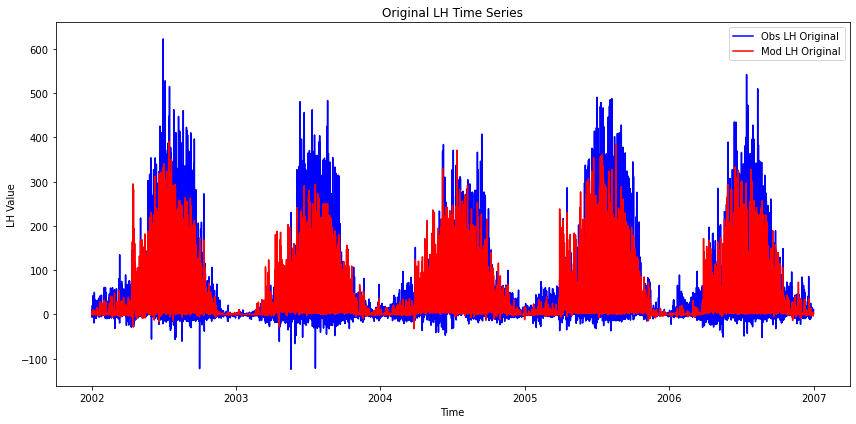

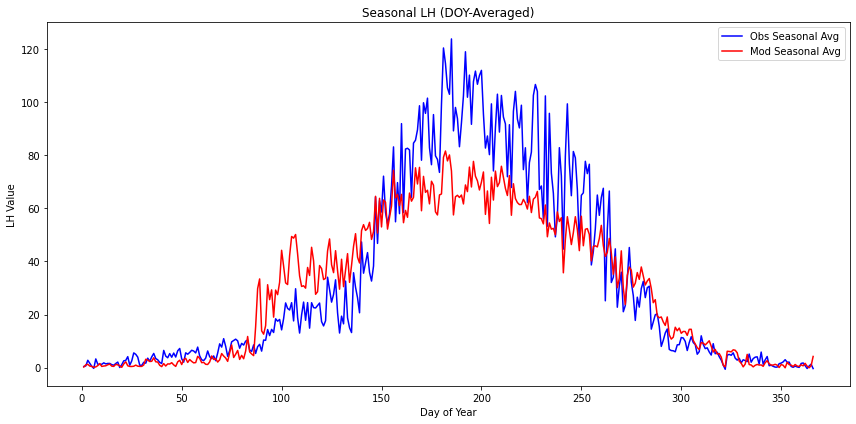

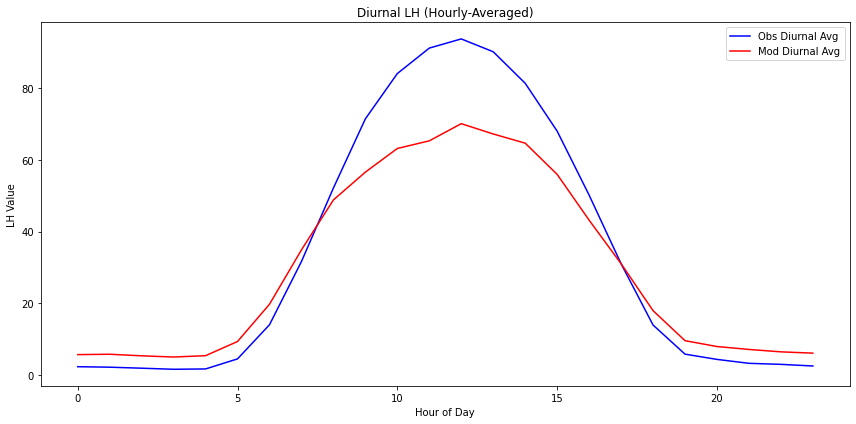

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat

def read_mat_file(file_path):
    """
    Load a MATLAB .mat file and return a dictionary of its data,
    filtering out MATLAB's metadata keys.
    """
    data = loadmat(file_path)
    return {k: v for k, v in data.items() if not k.startswith('__')}

def extract_timeseries(data, key):
    """
    Extract time and value arrays from a MATLAB MAT file structure.
    Expected structure for data[key]:
      - A NumPy array of shape (1,1) containing a tuple:
          (time_array, value_array)
    Both time_array and value_array are returned as 1D NumPy arrays.
    """
    arr = data[key]
    # Expect arr to have one element; extract the tuple from [0,0]
    tuple_data = arr[0, 0]
    time_array = np.atleast_1d(tuple_data[0]).flatten()
    value_array = np.atleast_1d(tuple_data[1]).flatten()
    return time_array, value_array

# --- Load MAT files ---
obs_data = read_mat_file("LH_US_Syv_obs2002010107_2006123123.mat")
mod_data = read_mat_file("LH_Noah-MP-PHS_mod2002010107_2006123123.mat")

# --- Print contents (for verification) ---
print("Observation MAT file contents:")
for key, value in obs_data.items():
    print(key, ":", value)

print("\nModeling MAT file contents:")
for key, value in mod_data.items():
    print(key, ":", value)

# --- Extract Original Time Series Data ---
obs_time_str, obs_values = extract_timeseries(obs_data, "LH_obs_original")
mod_time_str, mod_values = extract_timeseries(mod_data, "LH_mod_original")

# Convert time strings to datetime objects for plotting
obs_time_dt = pd.to_datetime(obs_time_str)
mod_time_dt = pd.to_datetime(mod_time_str)

# Plot Original Time Series
plt.figure(figsize=(12, 6))
plt.plot(obs_time_dt, obs_values, label="Obs LH Original", color="blue")
plt.plot(mod_time_dt, mod_values, label="Mod LH Original", color="red")
plt.xlabel("Time")
plt.ylabel("LH Value")
plt.title("Original LH Time Series")
plt.legend()
plt.tight_layout()
plt.show()

# --- Extract Seasonal (DOY-Averaged) Data ---
obs_seasonal_days, obs_seasonal_values = extract_timeseries(obs_data, "LH_obs_seasonal_avg_366")
mod_seasonal_days, mod_seasonal_values = extract_timeseries(mod_data, "LH_mod_seasonal_avg_366")

# Plot Seasonal Time Series
plt.figure(figsize=(12, 6))
plt.plot(obs_seasonal_days, obs_seasonal_values, label="Obs Seasonal Avg", color="blue")
plt.plot(mod_seasonal_days, mod_seasonal_values, label="Mod Seasonal Avg", color="red")
plt.xlabel("Day of Year")
plt.ylabel("LH Value")
plt.title("Seasonal LH (DOY-Averaged)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Extract Diurnal (Hourly-Averaged) Data ---
obs_diurnal_hours, obs_diurnal_values = extract_timeseries(obs_data, "LH_obs_diurnal_avg_24")
mod_diurnal_hours, mod_diurnal_values = extract_timeseries(mod_data, "LH_mod_diurnal_avg_24")

# Plot Diurnal Time Series
plt.figure(figsize=(12, 6))
plt.plot(obs_diurnal_hours, obs_diurnal_values, label="Obs Diurnal Avg", color="blue")
plt.plot(mod_diurnal_hours, mod_diurnal_values, label="Mod Diurnal Avg", color="red")
plt.xlabel("Hour of Day")
plt.ylabel("LH Value")
plt.title("Diurnal LH (Hourly-Averaged)")
plt.legend()
plt.tight_layout()
plt.show()


Observation MAT file contents:
LH_obs_original : [[(array(['2002-01-01 07:00:00', '2002-01-01 08:00:00',
         '2002-01-01 09:00:00', ..., '2006-12-31 21:00:00',
         '2006-12-31 22:00:00', '2006-12-31 23:00:00'], dtype='<U19'), array([[-0.6893735,  0.659024 ,  1.052547 , ...,  8.558781 ,  9.4838   ,
           8.58471  ]], dtype=float32))                                                                                                        ]]
LH_obs_seasonal_avg_366 : [[(array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
           14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
           27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
           40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
           53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
           66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
           79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90

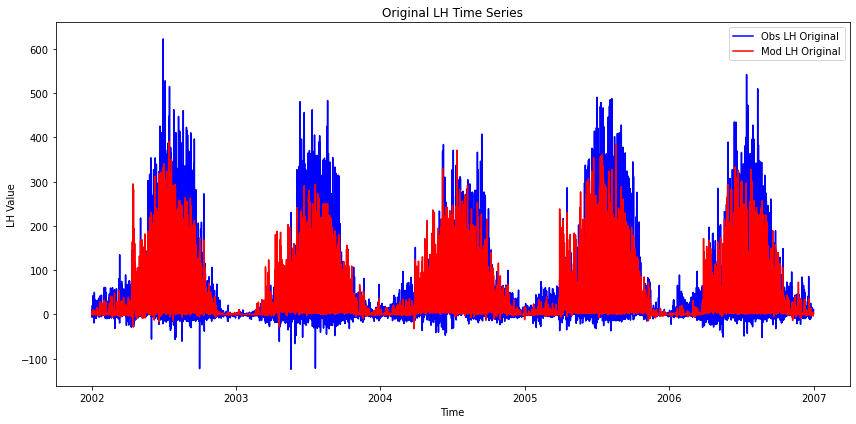

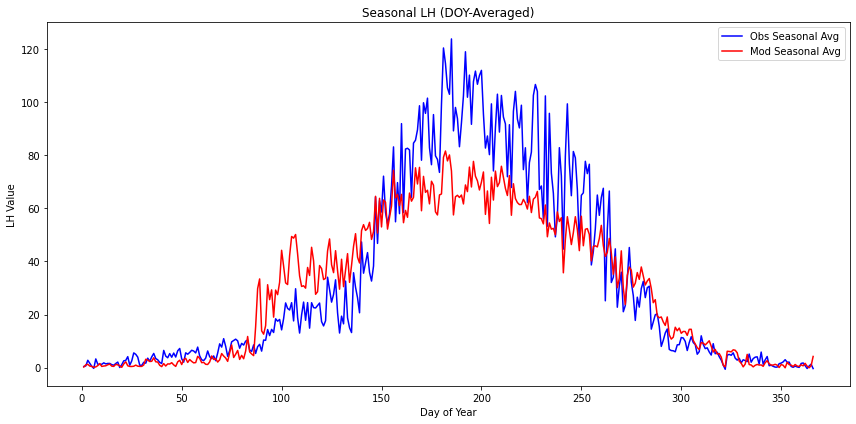

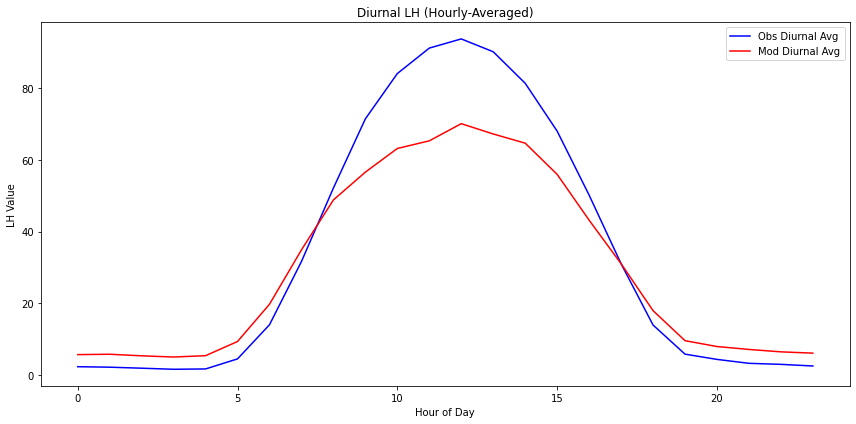

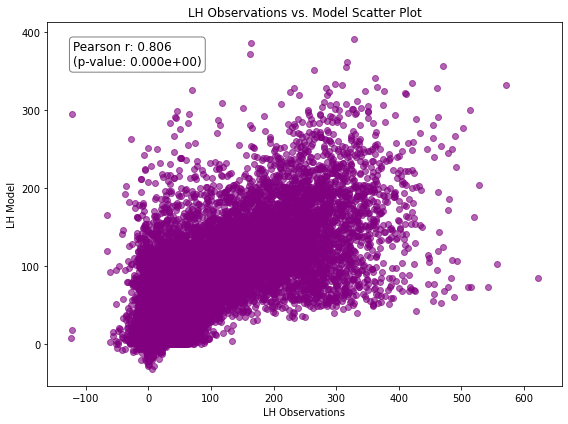

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import scipy.stats

def read_mat_file(file_path):
    """
    Load a MATLAB .mat file and return a dictionary of its data,
    filtering out MATLAB's metadata keys.
    """
    data = loadmat(file_path)
    return {k: v for k, v in data.items() if not k.startswith('__')}

def extract_timeseries(data, key):
    """
    Extract time and value arrays from a MATLAB MAT file structure.
    Expected structure for data[key]:
      - A NumPy array of shape (1,1) containing a tuple:
          (time_array, value_array)
    Both time_array and value_array are returned as 1D NumPy arrays.
    """
    arr = data[key]
    # Expect arr to have one element; extract the tuple from [0,0]
    tuple_data = arr[0, 0]
    time_array = np.atleast_1d(tuple_data[0]).flatten()
    value_array = np.atleast_1d(tuple_data[1]).flatten()
    return time_array, value_array

# --- Load MAT files ---
obs_data = read_mat_file("LH_US_Syv_obs2002010107_2006123123.mat")
mod_data = read_mat_file("LH_Noah-MP-PHS_mod2002010107_2006123123.mat")

# --- Print contents (for verification) ---
print("Observation MAT file contents:")
for key, value in obs_data.items():
    print(key, ":", value)

print("\nModeling MAT file contents:")
for key, value in mod_data.items():
    print(key, ":", value)

# --- Extract Original Time Series Data ---
obs_time_str, obs_values = extract_timeseries(obs_data, "LH_obs_original")
mod_time_str, mod_values = extract_timeseries(mod_data, "LH_mod_original")

# Convert time strings to datetime objects for plotting
obs_time_dt = pd.to_datetime(obs_time_str)
mod_time_dt = pd.to_datetime(mod_time_str)

# --- Plot Original Time Series ---
plt.figure(figsize=(12, 6))
plt.plot(obs_time_dt, obs_values, label="Obs LH Original", color="blue")
plt.plot(mod_time_dt, mod_values, label="Mod LH Original", color="red")
plt.xlabel("Time")
plt.ylabel("LH Value")
plt.title("Original LH Time Series")
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Seasonal (DOY-Averaged) Time Series ---
obs_seasonal_days, obs_seasonal_values = extract_timeseries(obs_data, "LH_obs_seasonal_avg_366")
mod_seasonal_days, mod_seasonal_values = extract_timeseries(mod_data, "LH_mod_seasonal_avg_366")

plt.figure(figsize=(12, 6))
plt.plot(obs_seasonal_days, obs_seasonal_values, label="Obs Seasonal Avg", color="blue")
plt.plot(mod_seasonal_days, mod_seasonal_values, label="Mod Seasonal Avg", color="red")
plt.xlabel("Day of Year")
plt.ylabel("LH Value")
plt.title("Seasonal LH (DOY-Averaged)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Diurnal (Hourly-Averaged) Time Series ---
obs_diurnal_hours, obs_diurnal_values = extract_timeseries(obs_data, "LH_obs_diurnal_avg_24")
mod_diurnal_hours, mod_diurnal_values = extract_timeseries(mod_data, "LH_mod_diurnal_avg_24")

plt.figure(figsize=(12, 6))
plt.plot(obs_diurnal_hours, obs_diurnal_values, label="Obs Diurnal Avg", color="blue")
plt.plot(mod_diurnal_hours, mod_diurnal_values, label="Mod Diurnal Avg", color="red")
plt.xlabel("Hour of Day")
plt.ylabel("LH Value")
plt.title("Diurnal LH (Hourly-Averaged)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Compute and Plot Pearson Correlation Coefficient (Scatter Plot) ---
# Compute Pearson correlation for the original LH series
r, p = scipy.stats.pearsonr(obs_values, mod_values)

plt.figure(figsize=(8, 6))
plt.scatter(obs_values, mod_values, color='purple', alpha=0.6)
plt.xlabel("LH Observations")
plt.ylabel("LH Model")
plt.title("LH Observations vs. Model Scatter Plot")
plt.text(0.05, 0.95, f'Pearson r: {r:.3f}\n(p-value: {p:.3e})',
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
plt.tight_layout()
plt.show()
